# Viz

In [2]:
import os
import sys

root_dir = "NYU_DL_Sys_Project"
cur_dir = os.getcwd().split("/")[-1]
while cur_dir != root_dir:
    os.chdir("..")
    cur_dir = os.getcwd().split("/")[-1]

In [5]:
import torch
from task_models.text_cls_model import TextCLSLightningModule

In [4]:
ckpt_path = "cached_models/active_learning/vinai/bertweet-covid19-base-cased_random_0/epoch=00-val/f1=0.20.ckpt"

In [7]:
from argparse import Namespace

args = {"backbone_name": "vinai/bertweet-covid19-base-cased", "num_labels": 16, "tokenizer_name": "roberta-base", "load_classifier": None}
args = Namespace(**args)
model = TextCLSLightningModule.load_from_checkpoint(ckpt_path, args=args)

Some weights of the model checkpoint at vinai/bertweet-covid19-base-cased were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-covid19-base-cased

In [9]:
model.net.roberta

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(130, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [22]:
import torch
from sklearn.manifold import TSNE 
import pandas as pd
import numpy as np

In [51]:
embeddings = np.load("./viz/feature_domain_0.npy")
y = np.load("./viz/label_domain_0.npy")

In [52]:
embeddings.shape

(1007, 768)

In [56]:
class_embeddings = [[] for i in range(16)]
for i in range(len(embeddings)):
    class_embeddings[y[i]].append(embeddings[i])

for i in range(16):
    class_embeddings[i] = np.array(class_embeddings[i])
    class_embeddings[i] = class_embeddings[i].mean(axis=0)

# get distance matrix
l2_dist_matrix = np.zeros((16, 16))
cos_dist_matrix = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if class_embeddings[i] is None or class_embeddings[j] is None:
            l2_dist_matrix[i, j] = -1
            cos_dist_matrix[i, j] = -1
            continue
        l2_dist_matrix[i][j] = np.linalg.norm(class_embeddings[i] - class_embeddings[j])
        cos_dist_matrix[i][j] = np.dot(class_embeddings[i], class_embeddings[j]) / (np.linalg.norm(class_embeddings[i]) * np.linalg.norm(class_embeddings[j]))

print(cos_dist_matrix, l2_dist_matrix)
max_l2_dist = np.max(l2_dist_matrix)
real_dist = l2_dist_matrix[l2_dist_matrix != 0]
min_l2_dist = np.min(real_dist)
mean_l2_dist = np.mean(l2_dist_matrix)
print(max_l2_dist, min_l2_dist, mean_l2_dist)


# do same for cosine distance
max_cos_dist = np.max(cos_dist_matrix)
real_dist = cos_dist_matrix[cos_dist_matrix != 0]
min_cos_dist = np.min(real_dist)
mean_cos_dist = np.mean(cos_dist_matrix)
print(max_cos_dist, min_cos_dist, mean_cos_dist)

# append to df
df = pd.read_csv("./viz/dist_matrix.csv")
log_name = "bertweet-covid19-base-cased_random_0"
df.loc[len(df)] = [log_name, max_l2_dist, min_l2_dist, mean_l2_dist, max_cos_dist, min_cos_dist, mean_cos_dist]

[[0.99999994 0.99837178 0.99721825 0.99672222 0.99926275 0.99726665
  0.99728036 0.99907631 0.99745136 0.99729651 0.99731195 0.99929982
  0.99703979 0.99869686 0.99812156 0.99810863]
 [0.99837178 1.         0.99538362 0.99452037 0.99741781 0.99584275
  0.996104   0.99782848 0.99430263 0.99673289 0.99539977 0.99824744
  0.99490863 0.99595326 0.99638289 0.99579191]
 [0.99721825 0.99538362 0.99999994 0.99914157 0.99703568 0.99162883
  0.99808097 0.99645835 0.99779326 0.99843866 0.99936843 0.99657518
  0.99426836 0.99713421 0.99405462 0.99792892]
 [0.99672222 0.99452037 0.99914157 1.         0.99690861 0.99111784
  0.99774611 0.99575096 0.99805611 0.99830067 0.9989599  0.99558473
  0.99389076 0.99750936 0.99355    0.9979614 ]
 [0.99926275 0.99741781 0.99703568 0.99690861 1.00000012 0.99790817
  0.9966855  0.99857926 0.99777895 0.996916   0.99743325 0.99890971
  0.99778008 0.99890292 0.99847126 0.9983573 ]
 [0.99726665 0.99584275 0.99162883 0.99111784 0.99790817 1.
  0.99208367 0.9971754  0

In [38]:
class_embeddings[1]

array([ 6.37468472e-02, -2.39061769e-02,  6.82541803e-02, -3.18845250e-02,
        1.66694522e-01,  3.85145873e-01,  1.97373610e-02, -3.01523749e-02,
       -1.04211502e-01, -1.14099376e-01,  4.91853319e-02,  2.88651437e-02,
        6.47004992e-02, -4.53763276e-01,  3.63526754e-02,  5.42971849e-01,
       -1.82647243e-01,  1.45558730e-01, -1.92804694e-01, -3.49248014e-03,
       -4.35997136e-02,  6.31476641e-02, -6.22512214e-02, -6.90753013e-02,
        3.48947719e-02, -4.14513946e-01,  6.36173971e-03,  9.82955992e-02,
        6.01895154e-02, -4.59731698e-01, -5.89244254e-03, -6.08128905e-02,
        3.50111604e-01,  2.52718776e-01,  6.10442869e-02,  3.22756737e-01,
       -6.89632669e-02,  2.12446406e-01, -2.22175568e-02,  2.88198978e-01,
        4.74501438e-02, -3.03783536e-01,  2.98574120e-01, -1.21863306e-01,
       -1.43006459e-01, -5.68592437e-02,  1.99230924e-01,  9.75138173e-02,
        3.22396867e-02, -1.01615615e-01,  1.01355754e-01, -8.49611834e-02,
        2.96093136e-01, -

In [24]:
y

array([ 5,  1,  3,  8,  0,  2, 13,  0, 14,  7,  1,  3, 12,  2,  3,  4,  3,
       12,  0,  9,  9,  0,  0,  8,  6,  1,  1, 11,  7,  9,  2, 13,  0,  4,
        1, 12,  2,  0,  1,  6,  1,  0,  8,  3,  0, 14,  0, 12,  0, 11,  7,
        0,  0,  7, 10,  2,  4,  0,  7, 13,  2, 10,  2,  0,  9,  5,  1,  2,
        7,  0,  5,  1,  3,  3,  1, 14,  3, 14,  0,  5,  7,  0,  5,  5,  0,
        7,  5,  9,  0,  0,  0,  1,  0,  2,  0,  7, 13,  0, 11, 13,  4,  5,
        6,  7,  6, 10, 10,  5,  6,  5,  6,  1,  8,  3,  5,  5,  9,  4,  2,
        3,  6,  0,  0,  2,  9])

In [18]:
tsne = TSNE(n_components=2, init='random', perplexity=30, early_exaggeration=100) 
X_tsne = tsne.fit_transform(embeddings) 
X_tsne_data = np.vstack((X_tsne.T, y)).T 
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class']) 
df_tsne.head()
df_tsne['class'] = df_tsne['class'].astype(int)
df_tsne.to_csv(f"./viz/tsne_test")

/opt/anaconda/envs/310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
X_tsne.shape

(125, 2)

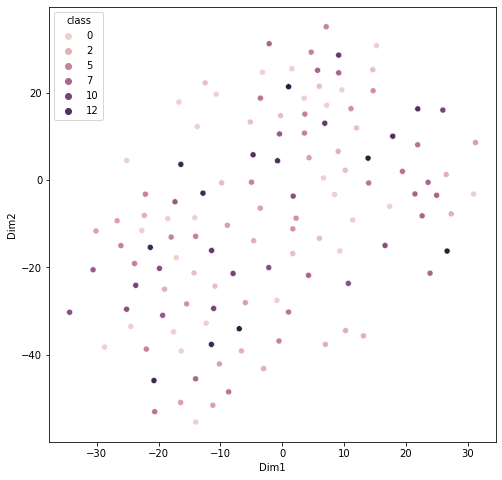

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=df_tsne, hue='class', x='Dim1', y='Dim2') 
plt.savefig(f"./viz/tsne_test_fig")